# Training models

This notebook shows how to train a pass success model using XGBoost.

In [1]:
from pathlib import Path
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt

import mlflow
from xgboost import XGBClassifier
import torch

/home/toc3/anaconda3/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4)/charset_normalizer (3.2.0) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [4]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_success, pass_selection
from unxpass.components.utils import log_model, load_model, save_model
from unxpass.visualization import plot_action

/home/toc3/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

We assume you've already generated a training and test with all required features and labels. If not, you can do this from the command line with:

```
unxpass create-dataset \
  sqlite://$(pwd)/stores/database.sqlite \
  $(pwd)/stores/datasets/default/train \
  $(pwd)/config/dataset/train.yaml
```

```
unxpass create-dataset \
  sqlite://$(pwd)/stores/database.sqlite \
  $(pwd)/stores/datasets/default/test \
  $(pwd)/config/dataset/test.yaml
```

Alternatively, the notebook titled "2-computing-and-storing-features" explains how to do this using the API.

xGBoost는 train-test로만 split해놓으면 됨(XGBoostComponent) \
train코드 내에서 train-valid 나눈 다음 model.fit하므로

SoccerMap는 train-valid-test split한 후 각 step하므로 3개로 분리해놓아야함

In [13]:
train_DB_PATH = Path("../stores/train-database.sqlite")
train_db = SQLiteDatabase(train_DB_PATH)

test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

In [14]:
STORES_FP = Path("../stores")

dataset_train = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "train")
dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "test")

## Configure model

Now we have to define the hyperparameters of the XGBoost model and the features to use. The features should be specified as a dictionary, where the key is the name of the feature generator and the values are the features that should be included (a generator can generate multiple features). The docstring of each feature generator provides details about the features it generates. Note that the suffix "a0" indicates that a feature is computed for the pass action, "a1" is the action before the pass, and so on.

In [15]:
model = pass_success.XGBoostComponent(
    model=XGBClassifier(
        objective="binary:logistic", 
        eval_metric="auc"
        # you probably want to do some hyperparameter tuning here to get a good model
    ),
    features={
        'startpolar': [
            'start_dist_to_goal_a0',
            'start_angle_to_goal_a0'
        ],
        'relative_startlocation': [
            'start_dist_goalline_a0',
            'start_dist_sideline_a0'
        ],
        'endpolar': [
            'end_dist_to_goal_a0',
            'end_angle_to_goal_a0'
        ],
        'relative_endlocation': [
            'end_dist_goalline_a0',
            'end_dist_sideline_a0'
        ],
        'movement': [
            'movement_a0',
            'dx_a0',
            'dy_a0'
        ],
        'angle': [
            'angle_a0'
        ],
        'ball_height_onehot': [
            'ball_height_ground_a0',
            'ball_height_low_a0',
            'ball_height_high_a0'
        ],
        'player_possession_time': [
            'player_possession_time_a0'
        ],
        'speed': [
            'speed_a01',
            'speed_a02'
        ],
        'under_pressure': [
            'under_pressure_a0'
        ],
        'dist_defender': [
            'dist_defender_start_a0',
            'dist_defender_end_a0',
            'dist_defender_action_a0'
        ],
        'nb_opp_in_path': [
            'nb_opp_in_path_a0'
        ]
    }, 
)

## Train and test model

In [16]:
model.train(dataset_train)

[10/10/23 15:53:38] INFO     Fitting model on train set                                             ]8;id=212015;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=915669;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

[0]	validation_0-auc:0.91235
[1]	validation_0-auc:0.91994
[2]	validation_0-auc:0.92723
[3]	validation_0-auc:0.92850
[4]	validation_0-auc:0.93117
[5]	validation_0-auc:0.93145
[6]	validation_0-auc:0.93119
[7]	validation_0-auc:0.93146
[8]	validation_0-auc:0.92952
[9]	validation_0-auc:0.93078
[10]	validation_0-auc:0.93007
[11]	validation_0-auc:0.93178
[12]	validation_0-auc:0.93230
[13]	validation_0-auc:0.93288
[14]	validation_0-auc:0.93126
[15]	validation_0-auc:0.93236
[16]	validation_0-auc:0.93260
[17]	validation_0-auc:0.93206
[18]	validation_0-auc:0.93155
[19]	validation_0-auc:0.93248
[20]	validation_0-auc:0.93207
[21]	validation_0-auc:0.93204
[22]	validation_0-auc:0.93205
[23]	validation_0-auc:0.93229
[24]	validation_0-auc:0.93202
[25]	validation_0-auc:0.93208
[26]	validation_0-auc:0.93218
[27]	validation_0-auc:0.93246
[28]	validation_0-auc:0.93231
[29]	validation_0-auc:0.93066
[30]	validation_0-auc:0.93070
[31]	validation_0-auc:0.93062
[32]	validation_0-auc:0.93016
[33]	validation_0-au

In [11]:
model.test(dataset_test)

ValueError: could not determine the shape of object type 'DataFrame'

In [11]:
a = pass_success.SoccerMapComponent(
    pass_success.PytorchSoccerMapModel()) 

/home/toc3/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/toc3/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:590: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  "The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0."
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
a

In [12]:
a.train(dataset_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type      | Params
----------------------------------------
0 | model     | SoccerMap | 275 K 
1 | sigmoid   | Sigmoid   | 0     
2 | criterion | BCELoss   | 0     
----------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.103     Total estimated model params size (MB)


subset sampler value counts : train:[3055, 23130] & valid:[1018, 7711]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
a

In [33]:
import joblib

In [35]:
with open('./Pretrained_model/soccer_map_component.pkl', 'wb') as file:
    joblib.dump(a, file)

NameError: name 'joblib' is not defined

In [20]:
result = a.test(dataset_test)

pass success model testing: 100%|██████████| 284/284 [01:31<00:00,  3.09it/s]


In [27]:
from pathlib import Path

In [29]:
a.save(path=Path('./Pretrained_model/pass_success_component.pkl'))

AttributeError: Can't pickle local object 'intended.<locals>._wrapper'

In [31]:
a.pr

PytorchSoccerMapModel(
  (model): SoccerMap(
    (features_x1): _FeatureExtractionLayer(
      (conv_1): Conv2d(15, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (symmetric_padding): ReplicationPad2d((2, 2, 2, 2))
    )
    (features_x2): _FeatureExtractionLayer(
      (conv_1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (symmetric_padding): ReplicationPad2d((2, 2, 2, 2))
    )
    (features_x4): _FeatureExtractionLayer(
      (conv_1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (symmetric_padding): ReplicationPad2d((2, 2, 2, 2))
    )
    (up_x2): _UpSamplingLayer(
      (up): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), s

In [14]:
mlflow.set_experiment(experiment_name="pass_success/threesixty")
modelinfo = log_model(a, artifact_path="component")
print(f"Model saved as {modelinfo.model_uri}")
b = load_model(modelinfo.model_uri)
print(b)

AttributeError: Can't pickle local object 'intended.<locals>._wrapper'

In [10]:
# You can now log the model in the MLFflow registry
mlflow.set_experiment(experiment_name="pass_success/threesixty")
modelinfo = log_model(model, artifact_path="component")
print(f"Model saved as {modelinfo.model_uri}")

2023/10/03 15:14:32 INFO mlflow.tracking.fluent: Experiment with name 'pass_success/threesixty' does not exist. Creating a new experiment.


Model saved as runs:/c3d2602a67b345ef823e05427a8e373e/component


In [11]:
modelinfo

In [12]:
modelinfo.model_uri

'runs:/c3d2602a67b345ef823e05427a8e373e/component'

In [14]:
# Then you can reload it later
# model = load_model("runs:/1353b9d8d56e4cdc843719f70aab0c4c/component")
model = load_model(modelinfo.model_uri)

In [15]:
model

In [19]:
save_model(model, path='./Pretrained_model/a')

In [21]:
load_model('./Pretrained_model/a')

In [16]:
# Next, evaluate how the model performs on a test set
model.test(dataset_test)

ValueError: could not determine the shape of object type 'DataFrame'

## Making predictions

Once trained, the model can be used to estimate the success probability of each pass in a dataset.

In [14]:
p_success = model.predict(dataset_test)
p_success

[07/29/23 00:58:22] INFO     Loading dataset from ../stores/datasets/default/test                   ]8;id=611726;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=215505;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

game_id  action_id
3788741  28           0.968557
         30           0.989717
         32           0.768555
         34           0.221375
         52           0.994890
                        ...   
3869685  2543         0.451086
         2555         0.999054
         2557         0.965747
         2564         0.597041
         2566         0.652929
Length: 11435, dtype: float32

Let's visualize what a pass what a high and a low success probability look like.

In [73]:
# easy_pass, hard_pass = (3795506, 4), (3795506, 2791)
# df_actions = db.actions(game_id=3795506)

# fig, ax = plt.subplots(1, 2, figsize=(12,4))
# plot_action(df_actions.loc[easy_pass], ax=ax[0])
# ax[0].set_title(f"P(success) = {p_success.loc[easy_pass]:.2f}")
# plot_action(df_actions.loc[hard_pass], ax=ax[1])
# ax[1].set_title(f"P(success) = {p_success.loc[hard_pass]:.2f}")
# plt.show()

Instead of predicting the success probability of the actual pass, we can also estimate the success probability of a pass towards every other location on the  pitch.

In [17]:
p_success_surfaces = model.predict_surface(dataset_test, game_id=3788743, db=test_db, x_bins=52, y_bins=34)

[07/29/23 00:58:38] INFO     Loading dataset from ../stores/datasets/default/test                   ]8;id=428316;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=306786;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

Output()

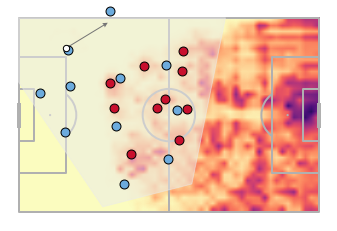

In [96]:
df_actions = test_db.actions(game_id=3788743)
sample = (3788743, 15)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_action(df_actions.loc[sample], surface=p_success_surfaces[f"action_{sample[1]}"], ax=ax, surface_kwargs={"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"})
plt.show()

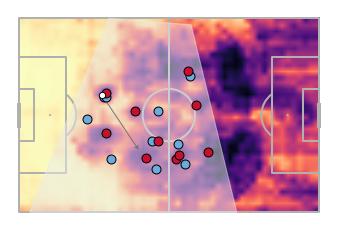

In [98]:
df_actions = test_db.actions(game_id=3788743)
sample = (3788743, 2206)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_action(df_actions.loc[sample], surface=p_success_surfaces[f"action_{sample[1]}"], ax=ax, surface_kwargs={"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"})
plt.show()

In [ ]:
db.close()